In [ ]:
!pip install transformers
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.cuda
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda


In [ ]:
import pandas as pd
import torch
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
labels1 = {'NOT': 0,
         'HOF': 1}

labels = {'NONE': 0,
         'HATE': 1,
         'PRFN': 2,
         'OFFN': 3}

def preprocess(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['tweet'] = data['tweet'].str.lower()
    data['tweet'] = data['tweet'].str.replace(r'(@\S+)', r' ', regex=True)
    data['tweet'] = data['tweet'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['tweet'] = data['tweet'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['tweet'] = data['tweet'].str.replace('[^\w\s]', '')                                                       # remove special characters
    data['tweet'] = data['tweet'].replace('\d', '', regex=True)
    data['tweet'] = data['tweet'].str.replace(r'[^\x00-\x7F]+', r' ', regex=True) 
    
    i = 0
    for index, row in data.iterrows():
        text = row['tweet']
        #word_tokens = tokenizer.tokenize(text)
        token_id = tokenizerTweet.encode(text)
        #filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": i,
            "Class": row['task_2'],
            "Tweet": text,
            'Token_id': token_id
        }, ignore_index=True)
        i = i + 1
    return df_

def pre2(data, columns):
    df_ = pd.DataFrame(columns=columns)
    
    i = 0
    for index, row in data.iterrows():
        text = row['tweet']
        token_id = tokenizerTweet.encode(text)
        #filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": i,
            "Class": row['subtask_a'],
            "Tweet": text,
            'Token_id': token_id
        }, ignore_index=True)
        i = i + 1
    return df_

In [ ]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
bertweet = bertweet.to(device)
tokenizerTweet= AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

data1 = pd.read_table('/content/drive/MyDrive/deepNN-labs/data/HASOCData/english_dataset.tsv')
data2 = pd.read_table('/content/drive/MyDrive/deepNN-labs/data/HASOCData/hasoc2019_en_test-2919.tsv')
columns = ['index', 'Tweet', 'Token_id','Class']
data = preprocess(data1, columns)

dataT = preprocess(data2, columns)



Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from sklearn.model_selection import train_test_split

#train, test = 

tex = pd.read_table('/content/drive/MyDrive/deepNN-labs/data/olid_pre/train.txt')

dataX = pre2(tex, columns)
train_samp = int(0.8*len(dataX))
val_samp = len(dataX) - train_samp
data, dataT = train_test_split(dataX, test_size=0.2)

In [ ]:
training_data = []

labels = {'NONE': 0,
         'HATE': 1,
         'PRFN': 2,
         'OFFN': 3}

labels1 = {'NOT': 0,
         'HOF': 1}

labels2 = {'NOT': 0,
         'OFF': 1}
#embed size 768

for _, n in data.iterrows():
    #print(n['index'])
    input_ids = torch.tensor([n['Token_id']]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-1]

    
    embeds = embeds.squeeze(0)
    #print(embeds.shape)
    training_data.append((embeds, labels[n['Class']]))

testing_data = []
for _, n in dataT.iterrows():
    #print(n['index'])
    input_ids = torch.tensor([n['Token_id']]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-1]

    
    embeds = embeds.squeeze(0)
    #print(embeds.shape)
    testing_data.append((embeds, labels[n['Class']]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(256 * 192, 120)
        self.fc2 = nn.Linear(120, 4)
        self.dropout = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 1, 768)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [ ]:
from sklearn.metrics import f1_score
def train_model(model, criterion, optimizer, lista, val, num_epochs):
    bestValLoss = 1000

    training_loss = []
    validation_loss = []
    for epochs in range(num_epochs):
        loss = 0
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        running_loss2 = 0.0
        correct_predictions2 = 0
        total_predictions2 = 0

        for batch_nr, (data, label) in enumerate(lista):
            #print("Data, ", data, "\n Labels: ", labels, "\n batch: ", batch_nr)
            prediction = model.forward(data)
            _, predicted = torch.max(prediction, 1)

            #label = to_onehot(label).to(device)
            label = label.to(device)
            loss = criterion(prediction, label)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item() * data.size(0)
            correct_predictions += (predicted == label).sum().item()
            total_predictions += label.size(0)

        
        ##Validation
        for batch_nr, (data, label) in enumerate(val):
            #print("Data, ", data, "\n Labels: ", labels, "\n batch: ", batch_nr)
            prediction = model.forward(data)
            _, predicted = torch.max(prediction, 1)

            label = label.to(device)
            loss = criterion(prediction, label)

            if (loss < bestValLoss):
                bestValLoss = loss
                torch.save(model, f="./test")
              
            running_loss2 += loss.item() * data.size(0)
            correct_predictions2 += (predicted == label).sum().item()
            total_predictions2 += label.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct_predictions / total_predictions

        epoch_loss2 = running_loss2 / len(val_loader.dataset)
        epoch_acc2 = correct_predictions2 / total_predictions2

        training_loss.append(epoch_loss)

        validation_loss.append(epoch_loss2)
        print(f"Epoch {epochs+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        print(f"Epoch {epochs+1}/{num_epochs}, Val_Loss: {epoch_loss2:.4f}, Val_Acc: {epoch_acc2:.4f}")

    return training_loss, validation_loss

def test(model, testData):
    model.eval()
    correct = 0
    total = 0
    listPred = []
    listTrue = []
    with torch.no_grad():
        for data, labels in testData:
            outputs = model.forward(data)
            _, pred = torch.max(outputs, 1)
            
            label = labels.to(device)
            
            correct += (pred == label).sum().item()
            for i in range(len(pred)):
                listPred.append(pred[i].cpu().item())
                #listPred.append(pred.data.cpu().numpy())
                listTrue.append(labels[i].cpu().item())
            total += label.size(0)

    f1 = f1_score(listTrue, listPred, average='weighted')  # 'weighted' takes into account label imbalance; it computes the average of the F1 score of each class weighted by their presence in the true data sample
    print('F1 Score:', f1)
    return listPred, listTrue

Epoch 1/30, Loss: 1.1207, Acc: 0.5939
Epoch 1/30, Val_Loss: 1.0755, Val_Acc: 0.6328
Epoch 2/30, Loss: 1.1072, Acc: 0.5962
Epoch 2/30, Val_Loss: 1.0585, Val_Acc: 0.6328
Epoch 3/30, Loss: 1.0916, Acc: 0.5915
Epoch 3/30, Val_Loss: 1.0833, Val_Acc: 0.6029
Epoch 4/30, Loss: 1.0733, Acc: 0.5911
Epoch 4/30, Val_Loss: 1.0518, Val_Acc: 0.6345
Epoch 5/30, Loss: 1.0514, Acc: 0.5947
Epoch 5/30, Val_Loss: 1.0097, Val_Acc: 0.6328
Epoch 6/30, Loss: 1.0318, Acc: 0.5994
Epoch 6/30, Val_Loss: 0.9956, Val_Acc: 0.6328
Epoch 7/30, Loss: 1.0210, Acc: 0.6001
Epoch 7/30, Val_Loss: 1.0125, Val_Acc: 0.6080
Epoch 8/30, Loss: 1.0154, Acc: 0.6003
Epoch 8/30, Val_Loss: 0.9744, Val_Acc: 0.6208
Epoch 9/30, Loss: 0.9981, Acc: 0.6071
Epoch 9/30, Val_Loss: 0.9859, Val_Acc: 0.6430
Epoch 10/30, Loss: 0.9958, Acc: 0.5992
Epoch 10/30, Val_Loss: 0.9896, Val_Acc: 0.6362
Epoch 11/30, Loss: 0.9825, Acc: 0.6097
Epoch 11/30, Val_Loss: 1.0120, Val_Acc: 0.6379
Epoch 12/30, Loss: 0.9850, Acc: 0.6127
Epoch 12/30, Val_Loss: 0.9887, Va

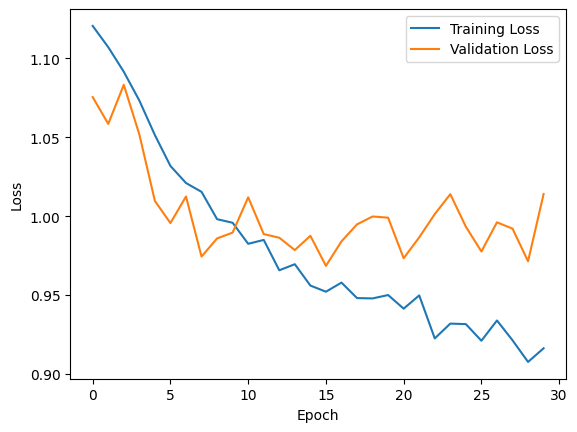

In [ ]:
LEARNING_RATE = 0.0001
to_onehot = nn.Embedding(4,4)
to_onehot.weight.data = torch.eye(4)
# Load our network
model = Net()
model = model.to(device)

# Define our loss function
class_weights = [0.1, 0.8, 0.9, 1.0]  # just an example, replace with your actual weights
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)




train_samp = int(0.8*len(training_data))
val_samp = len(training_data) - train_samp

train, val = torch.utils.data.random_split(training_data, [train_samp, val_samp], generator=torch.Generator())

dataloader = DataLoader(train, batch_size=32, shuffle=True)

val_loader = DataLoader(val, batch_size=32, shuffle=True)


# Define our optimizer

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=0.0005)

# Train the model
msg = "trainloss leaky relu and adam"
#trained_model = train_model(model, criterion, optimizer, dataloader, val_loader, 30)

training_loss, validation_loss = train_model(model, criterion, optimizer, dataloader, val_loader, 30)

import matplotlib.pyplot as plt

plt.plot(range(30), training_loss, label='Training Loss')
plt.plot(range(30), validation_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
tester = DataLoader(testing_data, batch_size=32, shuffle=False)
pred, true = test(model, tester)

F1 Score: 0.7128065434495418


In [ ]:
len(true)

Confusion matrix, without normalization
[[819  42   2   2]
 [ 76  43   2   3]
 [ 66  13  12   2]
 [ 49  15   6   1]]


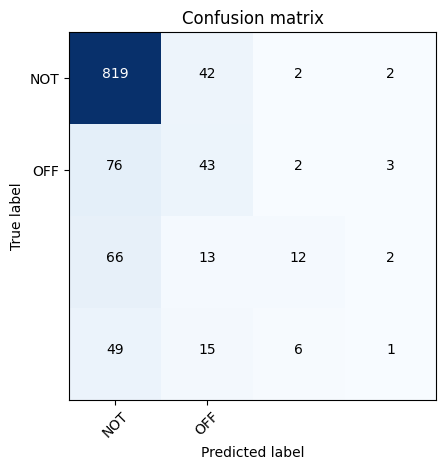

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(true, pred)
plot_confusion_matrix(cnf_matrix,labels2)